<a href="https://colab.research.google.com/github/anne-urai/ddm_mediation/blob/main/generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, set Runtime -> Runtime type -> GPU for fitting

# https://hddm.readthedocs.io/en/latest/lan_tutorial.html
!pip install scikit-learn
!pip install cython
!pip install pymc

# after making changes to the hddm forked repo, factory reset runtime
!pip install -U --no-deps git+https://github.com/anne-urai/hddm
!pip install -U --no-deps git+https://github.com/hddm-devs/kabuki

# MODULE IMPORTS ----
# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# to download data
from google.colab import files
import pprint

# HDDM
import hddm

     |████████████████████████████████| 385 kB 3.1 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1361119 sha256=16451cf781749ca14f43fcd87ab8d3c26b97fdac09b4a427ae8e7b4741752f1b
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc
  Cloning https://github.com/anne-urai/hddm to /tmp/pip-req-build-qbtszjwi
  Running command git clone -q https://github.com/anne-urai/hddm /tmp/pip-req-build-qbtszjwi
  Running command git submodule update --init --recursive -q
  Created wheel for HDDM: filename=HDDM-0.9.3-cp37-cp37m-linux_x86_64.whl size=3875321 sha256=b7eb8e38b4077d9df6f5b0ce016a9acb19e2d5b04730d033a415c09805896531
  Stored in directory: /tmp/pip-ephem-wheel-cache-gc8y6c33/wheels/fa/1c/d6/4d91002b5305b3dc76ca13cd496b9bbfd0fc9350d27ab615ca
Successfully built HDDM
  Cloning https://github.com/hddm-devs/kabuki to /tmp/pip-req-build-xij014f5
  Running command git clone -q https:/

In [4]:
##  ============================================================= ##
## generate some artificial choice data with mediation variable
##  ============================================================= ##

# first, previous choices ('X')
n_trials = int(1e4) # https://github.com/anne-urai/2019_Urai_choice-history-ddm/blob/master/simulations/1_ddm_rts.py#L84
n_subj = 20
df = pd.DataFrame(np.random.choice([-1,1], (n_trials*n_subj, 2)), columns=list('XS')) 

# make sure we have subj_idx and trial_idx
subj_idx = []
for s in np.arange(n_subj) + 1:
  for n in np.arange(n_trials):
    subj_idx.append(s)

trial_idx = []
for s in np.arange(n_subj) + 1:
  for n in np.arange(n_trials):
    trial_idx.append(n)

df['subj_idx'] = subj_idx
df['trial_idx'] = trial_idx
df.head(n=10)

,X,S,subj_idx,trial_idx
0,-1,-1,1,0
1,-1,1,1,1
2,1,1,1,2
3,-1,1,1,3
4,-1,1,1,4
5,-1,-1,1,5
6,-1,1,1,6
7,1,1,1,7
8,-1,-1,1,8
9,1,-1,1,9


In [34]:
# then a normally distributed random variable, that depends on X
a_path = np.random.normal(size=n_subj)

df['M'] = np.nan
for sjidx, (sj, sjdat) in enumerate(df.groupby(['subj_idx'])):
  this_M = np.random.normal(size=sjdat['X'].shape) + a_path[sjidx] * sjdat['X']
  df.loc[df.subj_idx == sj, 'M'] = this_M

df = df[['subj_idx', 'trial_idx', 'S', 'X', 'M']]
df.head(n=10)


,subj_idx,trial_idx,S,X,M
0,1,0,-1,-1,0.121635
1,1,1,1,-1,0.510288
2,1,2,1,1,-1.388459
3,1,3,1,-1,-0.397007
4,1,4,1,-1,0.155363
5,1,5,-1,-1,-1.184569
6,1,6,1,-1,0.276253
7,1,7,1,1,0.001855
8,1,8,-1,-1,1.596246
9,1,9,-1,1,-3.000801


In [41]:
a_df = pd.DataFrame()
a_df['subj_idx'] = df.subj_idx.unique()
a_df['a_path'] = a_path
a_df

,subj_idx,a_path
0,1,-0.752020
1,2,-1.088724
2,3,0.320764
3,4,-0.632134
4,5,0.976689
5,6,-1.180203
6,7,0.500705
7,8,-2.009680
8,9,0.650460
9,10,0.710912


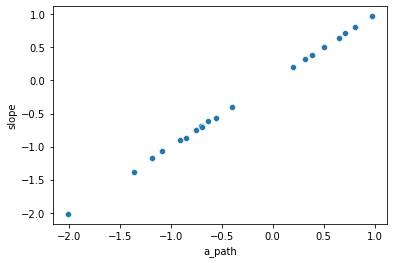

In [49]:
# DOES M DEPEND ON X (a-path)?
import statsmodels.api as sm
from patsy import dmatrices

a_df['intercept'] = np.nan
a_df['slope'] = np.nan
for sjidx, (sj, sjdat) in enumerate(df.groupby(['subj_idx'])):

  #fit linear regression model
  y, X = dmatrices('M ~ 1 + X', 
                   data=sjdat, return_type='dataframe')
  model = sm.OLS(y, X).fit()
  a_df.loc[a_df.subj_idx == sj, 'intercept'] = model.params[0]
  a_df.loc[a_df.subj_idx == sj, 'slope'] = model.params[1]

# # see the separation
# g = sns.FacetGrid(data=df, col='subj_idx', col_wrap=5, hue='X')
# g.map(sns.distplot, 'M')
sns.scatterplot(a_df.a_path, a_df.slope)

In [ ]:
##  ============================================================= ##
# plug into the HDDMnn simulator to simulate choices and RTs
##  ============================================================= ##

# help(hddm.simulators.hddm_dataset_generators.simulator_h_c)
# see https://hddm.readthedocs.io/en/latest/lan_tutorial.html#section-5-regressors 
# forum request for bug: https://groups.google.com/g/hddm-users/c/bdKDkwuQ3tk

for eff_x in ['v']: #, 'no']: #'z', 'vz', 'no']:
  for eff_m in ['v']: #, 'no']: # 'z', 'vz', 'no']:

  # simulate a couple of datasets: where X/M affects v/z/nothing
    regr_v = 'v ~ 1 + S'
    if 'v' in eff_x:
      regr_v = regr_v + ' + X'
    if 'v' in eff_m:
      regr_v = regr_v + ' + M'

    regr_z = 'z ~ 1'
    if 'z' in eff_x:
      regr_z = regr_z + ' + X'
    if 'z' in eff_m:
      regr_z = regr_z + ' + M'

    print(eff_x, '; ', 
          eff_m, '; ',
          regr_v, '; ',
          regr_z)

    # plug this into the simulator
    data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(data = df, 
                                                                                  model = 'ddm',
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, 
                                                                                  depends_on = None, 
                                                                                  regression_models = [regr_v, regr_z], 
                                                                                  regression_covariates = ['S', 'X'],
                                                                                  group_only = None,
                                                                                  group_only_regressors = False,
                                                                                  fixed_at_default = None)

    # export the parameter_dict into df
    # from https://github.com/anne-urai/MEG/blob/master/hddm_funcs_plot.py#L66
    # https://github.com/anne-urai/hddm/blob/master/hddm/utils.py#L925
    param_dict = {}
    for key, value in full_parameter_dict.items():
        if 'reg' not in key:
            param_dict[key] = value
    param_dict
    param_df = pd.DataFrame.from_dict(param_dict, orient='index').reset_index()
    param_df = hddm.utils.results_long2wide(param_df, 
                                            name_col="index", 
                                            val_col=0)
    # add the simulated a-path here
    param_df = pd.merge(param_df, a_df[['subj_idx', 'a_path']], on='subj_idx')

    # save the data and param_df to files for later fitting
    # see https://colab.research.google.com/notebooks/io.ipynb#scrollTo=p2E4EKhCWEC5
    param_df.to_csv('param_df_X%s_M%s.csv'%(eff_x, eff_m))
    files.download('param_df_X%s_M%s.csv'%(eff_x, eff_m))

    data.to_csv('data_df_X%s_M%s.csv'%(eff_x, eff_m))
    files.download('data_df_X%s_M%s.csv'%(eff_x, eff_m))

v ;  v ;  v ~ 1 + S + X + M ;  z ~ 1


/usr/local/lib/python3.7/dist-packages/hddm/simulators/hddm_dataset_generators.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[param] = 0
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation becau